In [3]:
import pandas as pd
import numpy as np
import joblib
import qiskit
import qiskit_machine_learning
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

print(f"Qiskit version: {qiskit.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Qiskit version: 2.3.0
Scikit-learn version: 1.7.2


In [ ]:
# Tải dữ liệu đã tiền xử lý
train_df = pd.read_csv('processed_data/pNSL_KDD_Train_Cleaned.csv')
test_df = pd.read_csv('processed_data/NSL_KDD_Test_Cleaned.csv')

# Lấy mẫu cân bằng (Balanced Sampling)
train_sample = pd.concat([
    train_df[train_df['label'] == 0].sample(50, random_state=42),
    train_df[train_df['label'] == 1].sample(50, random_state=42)
])
test_sample = pd.concat([
    test_df[test_df['label'] == 0].sample(15, random_state=42),
    test_df[test_df['label'] == 1].sample(15, random_state=42)
])

X_train = train_sample.drop('label', axis=1)
y_train = train_sample['label']
X_test = test_sample.drop('label', axis=1)
y_test = test_sample['label']

print(f"Kích thước tập huấn luyện: {X_train.shape}")

Kích thước tập huấn luyện: (100, 122)


In [7]:
num_qubits = 4
pca = PCA(n_components=num_qubits)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Tổng phương sai được giữ lại: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

Tổng phương sai được giữ lại: 75.75%


C:\Users\VITUS\AppData\Local\Temp\ipykernel_3204\2070292262.py:1: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')


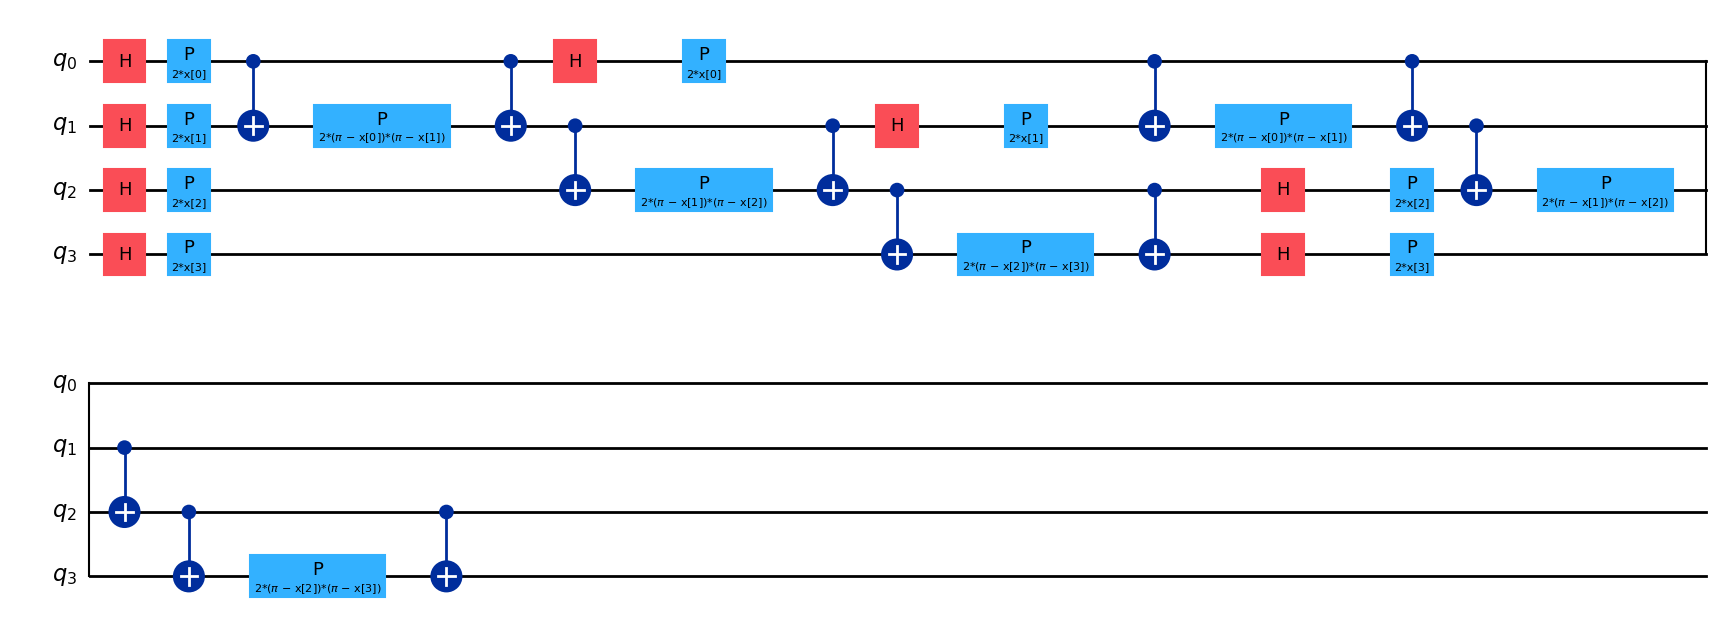

In [8]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')
sampler = Sampler() 
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# Vẽ mạch để kiểm tra (Trực quan hóa cho Paper)
feature_map.decompose().draw('mpl')

In [9]:
qsvc = QSVC(quantum_kernel=kernel)
print("Đang bắt đầu huấn luyện QSVM (có thể mất vài phút)...")
qsvc.fit(X_train_pca, y_train)

# Dự đoán và kiểm tra nhanh
y_pred = qsvc.predict(X_test_pca)
print("\n--- BÁO CÁO PHÂN LOẠI ---")
print(classification_report(y_test, y_pred))

Đang bắt đầu huấn luyện QSVM (có thể mất vài phút)...

--- BÁO CÁO PHÂN LOẠI ---
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        15
           1       0.92      0.80      0.86        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [10]:
model_data = {
    'pca_model': pca,
    'qsvm_model': qsvc,
    'metadata': {
        'num_qubits': num_qubits,
        'versions': {
            'qiskit': qiskit.__version__,
            'qiskit_ml': qiskit_machine_learning.__version__,
            'scikit_learn': sklearn.__version__,
            'joblib': joblib.__version__
        }
    }
}

joblib.dump(model_data, 'qsvm_research_model.pkl')
print("Model và thông tin phiên bản đã được lưu thành công!")

Model và thông tin phiên bản đã được lưu thành công!
